# From ConsIndShock to ConsPortfolio

In [1]:
# Import relevenat HARK tools
from HARK.ConsumptionSaving.ConsIndShockModel import (
    IndShockConsumerType,
    init_lifecycle,
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ConsPortfolioHousingModel import PortfolioRentalHousingType

pd.options.display.float_format = "{:,.2f}".format
pd.set_option("display.max_rows", None)

from IPython import get_ipython  # In case it was run from python instead of ipython


# If the ipython process contains 'terminal' assume not in a notebook
def in_ipynb():
    try:
        if "terminal" in str(type(get_ipython())):
            return False
        else:
            return True
    except NameError:
        return False


# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic("matplotlib", "inline")
else:
    get_ipython().run_line_magic("matplotlib", "auto")

# `IndShockConsumerType` Lifecycle

First, we set up an `IndShockConsumerType` agent with lifecycle parameters and a `CRRA` parameter of 4.0.

In [2]:
init_lifecycle["CRRA"] = 4.0
agent = IndShockConsumerType(**init_lifecycle)
agent.solve()

We can then simulate the agents for 1 lifecycle to record the average path of normalized assets, wealth, and consumption.

In [3]:
agent.track_vars = ["aNrm", "mNrm", "cNrm", "pLvl", "t_age"]
agent.T_sim = agent.T_age
agent.initialize_sim()
agent.simulate();

In [4]:
raw_data = {
    "Age": agent.history["t_age"].flatten() + 24,
    "pIncome": agent.history["pLvl"].flatten(),
    "nrmA": agent.history["aNrm"].flatten(),
    "nrmM": agent.history["mNrm"].flatten(),
    "nrmC": agent.history["cNrm"].flatten(),
}

data = pd.DataFrame(raw_data)

In [5]:
AgeMeans = data.groupby(["Age"]).mean().reset_index()
AgeMeans.head()

,Age,pIncome,nrmA,nrmM,nrmC
0,25.00,47.24,2.04,2.69,0.65
1,26.00,48.54,2.46,3.15,0.70
2,27.00,49.85,2.80,3.54,0.74
3,28.00,51.40,3.15,3.93,0.78
4,29.00,52.90,3.45,4.27,0.81


# `IndShockConsumerType` by 5 years

What we are interested in, however, is, a `IndShockConsumerType` agent with lifecycle properties who makes decisions every 5 years. To accomplish this task, the function `life_cycle_by_years` takes the original parameters and makes the necessary calculations to aggregate parameters to reflect 5 year periods. 

In [6]:
def life_cycle_by_years(lc_dict, years):
    lc_ret = lc_dict.copy()
    n = len(lc_dict["LivPrb"]) // years
    lc_ret["Rfree"] = lc_dict["Rfree"] ** years
    lc_ret["DiscFac"] = lc_dict["DiscFac"] ** years
    LivPrb = []
    for split in np.array_split(lc_dict["LivPrb"], n):
        LivPrb.append(np.prod(split))
    lc_ret["LivPrb"] = LivPrb

    PermGroFac = []
    for split in np.array_split(lc_dict["PermGroFac"], n):
        PermGroFac.append(np.prod(split))
    lc_ret["PermGroFac"] = PermGroFac

    lc_ret["T_age"] = lc_dict["T_age"] // years + 1
    lc_ret["T_cycle"] = lc_dict["T_cycle"] // years

    PermShkStd = []
    PermShkStd_temp = np.array(lc_dict["PermShkStd"])
    for split in np.array_split(PermShkStd_temp, n):
        PermShkStd.append(np.sqrt((split ** 2).sum()))
    lc_ret["PermShkStd"] = PermShkStd

    # not the right thing to do
    # transitory shocks average out over 5 year period
    TranShkStd = []
    TranShkStd_temp = np.array(lc_dict["TranShkStd"])
    for split in np.array_split(TranShkStd_temp, n):
        TranShkStd.append(np.sqrt((split ** 2).sum()))
    lc_ret["TranShkStd"] = TranShkStd

    lc_ret["UnempPrb"] = lc_dict["UnempPrb"] ** years

    return lc_ret

In [7]:
init_lifecycle_by_5 = life_cycle_by_years(init_lifecycle, 5)
init_lifecycle_by_5;

However, because the goal is to produce an agent that will be expanded to a `PortfolioRentalHousing` agent, we need to make some additional modifications to the initial parameters, such as making the lifespan deterministic and removing transitory shocks to income. 

In [8]:
init_lifecycle_by_5["TranShkStd"] = [0.0] * 13
init_lifecycle_by_5["TranShkCount"] = 1
init_lifecycle_by_5["LivPrb"] = [1.0] * 13
init_lifecycle_by_5["UnempPrb"] = 0
init_lifecycle_by_5["UnempPrbRet"] = 0

In [9]:
# init_lifecycle_by_5["DiscFac"] = init_lifecycle["DiscFac"]
agent = IndShockConsumerType(**init_lifecycle_by_5)
agent.solve()
agent.track_vars = ["aNrm", "mNrm", "cNrm", "pLvl", "t_age"]
agent.T_sim = agent.T_age
agent.initialize_sim()
agent.simulate();

After simulation, we can extract desired outcomes and summarize by age. 

In [10]:
raw_data = {
    "Age": agent.history["t_age"].flatten() * 5 + 20,
    "pIncome": agent.history["pLvl"].flatten(),
    "nrmA": agent.history["aNrm"].flatten(),
    "nrmM": agent.history["mNrm"].flatten(),
    "nrmC": agent.history["cNrm"].flatten(),
}

data = pd.DataFrame(raw_data)
AgeMeans = data.groupby(["Age"]).mean().reset_index()
AgeMeans

,Age,pIncome,nrmA,nrmM,nrmC
0,25.00,34.79,1.85,2.87,1.02
1,30.00,42.22,2.13,3.29,1.16
2,35.00,51.27,2.23,3.43,1.20
3,40.00,60.81,2.29,3.47,1.17
4,45.00,68.94,2.44,3.60,1.17
5,50.00,74.45,2.70,3.92,1.21
6,55.00,75.82,3.13,4.48,1.35
7,60.00,73.47,3.73,5.31,1.58
8,65.00,69.37,4.38,6.29,1.91
9,70.00,38.00,6.84,10.28,3.44


# `PortfolioRentalHousingType`

Now, taking the parameters of the `IndShockConsumerType` by 5 years, we add portfolio choice. 

In [11]:
# Calibrate the model in line with the information above
import sys, os

# The following code navigates to another directory where a python script with the parameters for the model is saved.
sys.path.append(os.path.realpath("Calibration/"))
# Loading the parameters from the Calibration/params.py script
from params import dict_portfolio, time_params, det_income, age_plot_params

In [12]:
# add RntHseShare to model, assuming households spend 30%
# of expenditures on rental housing
dict_portfolio.update(init_lifecycle_by_5)

dict_portfolio["RntHseShare"] = 0.30
dict_portfolio["ExRiskyShare"] = [0.8] * 7 + [0.4] * 6
dict_portfolio["WlthNrmAvg"] = np.linspace(2.87, 60, 13)
dict_portfolio["FixRiskyAvg"] = True
dict_portfolio["FixRiskyStd"] = False

In [13]:
dict_portfolio;

In [14]:
# Solve the model with the given parameters
agent = PortfolioRentalHousingType(**dict_portfolio)
agent.solve()

In [15]:
# Define a normalization factor
norm_factor = det_income * np.exp(0)

### Key Results

#### The optimal risky asset share

The plot below shows the policy function for the risky portfolio share as a function of wealth at different ages.

The optimal risky share is decreasing in wealth. The authors argue this is due to the fact that, at low levels of wealth, relatively safe human wealth represents a higher fraction of the consumer's wealth, so he shifts his tradeable wealth towards riskier alternatives.

Analyzing the policy rule by age also shows that the risky share increases from young to middle age, and decreases from middle to old age. This is consistent with the previous interpretation: shares trace the humped shape of labor earnings.

These estimates are different from what is produced in the original paper, which are also reproduced below. Generally, the policy functions do not share the same curvature, which leads to greater reductions in the optimal portfolio share at lower levels of wealth.

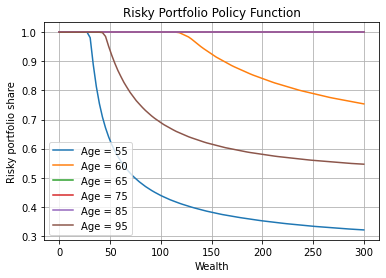

In [16]:
# Plot portfolio rule
eevalgrid = np.linspace(0, 300, 100)
plt.figure()
# In the last period of life you consume everything
# so portfolio choice is irrelevant

# Ages
ages = age_plot_params
age_born = 20
for a in ages:
    plt.plot(
        eevalgrid,
        agent.solution[a - age_born].ShareFuncAdj(
            eevalgrid / norm_factor[a - age_born]
        ),
        label="Age = %i" % (a * 5 + 25),
    )
plt.xlabel("Wealth")
plt.ylabel("Risky portfolio share")
plt.title("Risky Portfolio Policy Function")
plt.legend()
plt.grid()

if not in_ipynb():
    plt.show(block=False)
    plt.pause(1)
else:
    plt.show(block=True)

We present the author's originally reported policy functions for comparison
<center><img src="Figures\Opt_shares_by_age.jpg" style="height:300px"></center>

#### Consumption behavior

The plot below shows the policy functions for consumption, rental housing, and total expenditures as a function of wealth at different ages.

At all age levels consumption increases with wealth. The consumption function also appears to shift upwards as life progresses.

Our consumption policy functions again do not match those of the original paper, which are also reproduced below. Consumption also appears to increase with age in our policy functions that does not come through in the results presented in the paper.

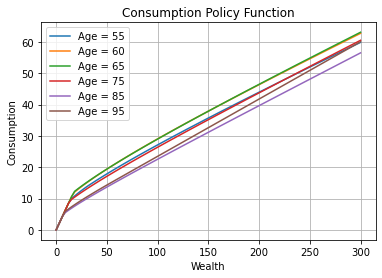

In [17]:
# Plot consumption function
plt.figure()
ages = age_plot_params
for a in ages:
    plt.plot(
        eevalgrid,
        agent.solution[a - age_born].cFuncAdj(eevalgrid / norm_factor[a - age_born])
        * norm_factor[a - age_born],
        label="Age = %i" % (a * 5 + 25),
    )
plt.xlabel("Wealth")
plt.ylabel("Consumption")
plt.title("Consumption Policy Function")
plt.legend()
plt.grid()

if not in_ipynb():
    plt.show(block=False)
    plt.pause(1)
else:
    plt.show(block=True)

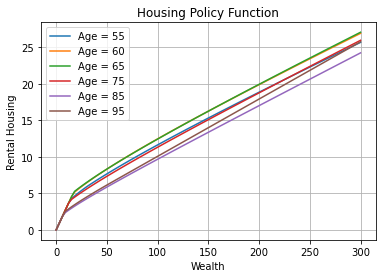

In [18]:
# Plot rental housing function
plt.figure()
ages = age_plot_params
for a in ages:
    plt.plot(
        eevalgrid,
        agent.solution[a - age_born].hFuncAdj(eevalgrid / norm_factor[a - age_born])
        * norm_factor[a - age_born],
        label="Age = %i" % (a * 5 + 25),
    )
plt.xlabel("Wealth")
plt.ylabel("Rental Housing")
plt.title("Housing Policy Function")
plt.legend()
plt.grid()

if not in_ipynb():
    plt.show(block=False)
    plt.pause(1)
else:
    plt.show(block=True)

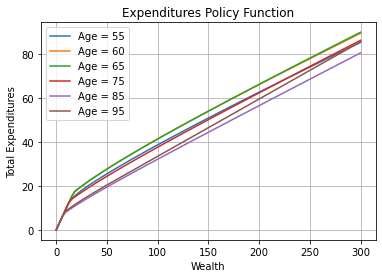

In [19]:
# Plot total expenditures function
plt.figure()
ages = age_plot_params
for a in ages:
    plt.plot(
        eevalgrid,
        agent.solution[a - age_born].TotalExpAdj(eevalgrid / norm_factor[a - age_born])
        * norm_factor[a - age_born],
        label="Age = %i" % (a * 5 + 25),
    )
plt.xlabel("Wealth")
plt.ylabel("Total Expenditures")
plt.title("Expenditures Policy Function")
plt.legend()
plt.grid()

if not in_ipynb():
    plt.show(block=False)
    plt.pause(1)
else:
    plt.show(block=True)

We again present the author's originally reported policy functions for comparison
<center><img src="Figures\Opt_cons_by_age.jpg" style="height:300px"></center>

### Simulations

Using the policy functions obtained from solving the model we present a series of simulations to highlight features of the model.

We first run a few simulations to verify the quality of our calibration.

The figures below show simulated levels of permanent income and risky portfolio shares for 5 agents over their life spans. We can see the model generates a heterogeneous permanent income distribution. Interestingly, all of these agents tend to follow the same general pattern for investing in the risky asset. Early in life, all of their portfolios are invested in the risky asset. This declines as the agent ages and converges to approximately 35% once they reach retirement.

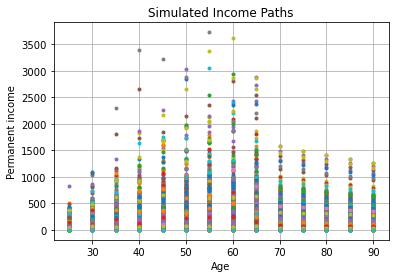

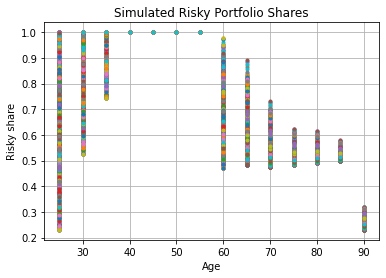

In [20]:
# Set up simulation parameters

# Number of agents and periods in the simulation.
# Since agents can die, they are replaced by a new agent whenever they do.

# Number of periods to be simulated
agent.T_sim = agent.T_age

# Set up the variables we want to keep track of.
agent.track_vars = ["aNrm", "cNrm", "pLvl", "t_age", "Share", "mNrm"]

# Run the simulations
agent.initialize_sim()
agent.simulate()

# Present diagnostic plots.
plt.figure()
plt.plot(agent.history["t_age"] * 5 + 20, agent.history["pLvl"], ".")
plt.xlabel("Age")
plt.ylabel("Permanent income")
plt.title("Simulated Income Paths")
plt.grid()

if not in_ipynb():
    plt.show(block=False)
    plt.pause(1)
else:
    plt.show(block=True)

plt.figure()
plt.plot(agent.history["t_age"] * 5 + 20, agent.history["Share"], ".")
plt.xlabel("Age")
plt.ylabel("Risky share")
plt.title("Simulated Risky Portfolio Shares")
plt.grid()

if not in_ipynb():
    plt.show(block=False)
    plt.pause(1)
else:
    plt.show(block=True)

#### The average life cycle patterns

We now increase the number of simulations to examine and compare the behavior of the mean values of variables of interest at different ages, conditional on survival. In each case we present the original plots from the paper for reference.

The plot below illustrates the average dynamics of permanent income, consumption, and market resources across all of the simulated agents. The plot follows the general pattern observed in the original paper. However, our results show that the agents are accumulating significantly more market resources.

In [21]:
raw_data = {
    "Age": agent.history["t_age"].flatten() * 5 + 20,
    "pIncome": agent.history["pLvl"].flatten(),
    "rShare": agent.history["Share"].flatten(),
    "nrmM": agent.history["mNrm"].flatten(),
    "nrmC": agent.history["cNrm"].flatten(),
}

Data = pd.DataFrame(raw_data)
Data["Cons"] = Data.nrmC * Data.pIncome
Data["M"] = Data.nrmM * Data.pIncome

# Find the mean of each variable at every age
AgeMeans = Data.groupby(["Age"]).mean().reset_index()

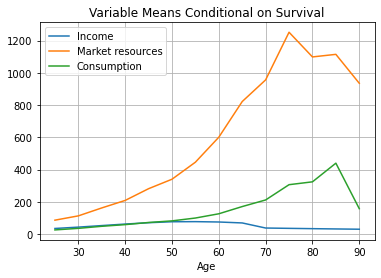

In [22]:
plt.figure()
plt.plot(AgeMeans.Age, AgeMeans.pIncome, label="Income")
plt.plot(AgeMeans.Age, AgeMeans.M, label="Market resources")
plt.plot(AgeMeans.Age, AgeMeans.Cons, label="Consumption")
plt.legend()
plt.xlabel("Age")
plt.title("Variable Means Conditional on Survival")
plt.grid()

if not in_ipynb():
    plt.show(block=False)
    plt.pause(1)
else:
    plt.show(block=True)

<center><img src="Figures\ConsWInc.jpg" style="height:300px"></center>

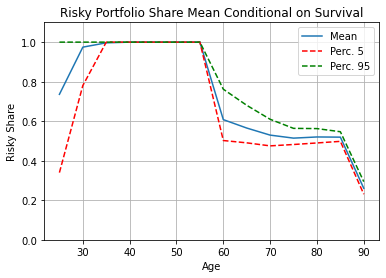

In [23]:
# Find age percentiles
AgePC5 = Data.groupby(["Age"]).quantile(0.05).reset_index()
AgePC95 = Data.groupby(["Age"]).quantile(0.95).reset_index()

# plot till death - 1
age_1 = time_params["Age_death"] - time_params["Age_born"]

plt.figure()
plt.ylim([0, 1.1])
plt.plot(AgeMeans.Age[:age_1], AgeMeans.rShare[:age_1], label="Mean")
plt.plot(AgePC5.Age[:age_1], AgePC5.rShare[:age_1], "--r", label="Perc. 5")
plt.plot(AgePC95.Age[:age_1], AgePC95.rShare[:age_1], "--g", label="Perc. 95")
plt.legend()

plt.xlabel("Age")
plt.ylabel("Risky Share")
plt.title("Risky Portfolio Share Mean Conditional on Survival")
plt.grid()

if not in_ipynb():
    plt.show(block=False)
    plt.pause(1)
else:
    plt.show(block=True)

<center><img src="Figures\ShareMeanSim.jpg" style="height:300px"></center>

In [24]:
AgeMeans["nrmH"] = agent.hNrm
AgeMeans["RiskyAvg"] = agent.RiskyAvg + [0]
AgeMeans["RiskyStd"] = agent.RiskyStd + [0]
AgeMeans["Share_at_mean_nrmM"] = (
    np.log(AgeMeans["RiskyAvg"] / agent.Rfree)
    * (1 + AgeMeans["nrmH"] / AgeMeans["nrmM"])
    / (agent.CRRA * np.log(1 + AgeMeans["RiskyStd"] ** 2 / AgeMeans["RiskyAvg"] ** 2))
)
AgeMeans

C:\Users\alujan\anaconda3\envs\PortfolioChoiceWithRiskyHousing-Latest\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Age,pIncome,rShare,nrmM,nrmC,Cons,M,nrmH,RiskyAvg,RiskyStd,Share_at_mean_nrmM
0,25.00,35.41,0.74,2.86,0.81,26.45,86.88,8.67,1.47,0.87,0.80
1,30.00,43.79,0.97,3.49,0.98,36.17,113.48,7.19,1.47,0.58,1.26
2,35.00,53.32,1.00,4.48,1.16,48.90,162.65,5.88,1.47,0.50,1.26
3,40.00,62.77,1.00,5.05,1.24,59.19,209.20,4.80,1.47,0.46,1.22
4,45.00,71.09,1.00,6.22,1.40,72.53,281.91,3.92,1.47,0.44,1.11
5,50.00,77.06,1.00,7.21,1.55,82.48,340.56,3.22,1.47,0.43,1.03
6,55.00,77.73,1.00,9.95,2.01,100.10,446.17,2.64,1.47,0.42,0.93
7,60.00,75.54,0.61,15.26,2.92,126.45,600.99,2.13,1.47,0.61,0.43
8,65.00,69.65,0.57,24.13,4.71,171.20,822.08,1.64,1.47,0.60,0.41
9,70.00,38.15,0.53,50.20,10.63,212.12,956.33,2.48,1.47,0.60,0.40


In [25]:
diff = set(dict_portfolio) - set(init_lifecycle_by_5)

# Printing difference in
# keys in two dictionary
print(diff)

{'ExRiskyShareBool', 'RntHseShare', 'RiskyAvg', 'ExRiskyShare', 'cycles', 'RiskyShareCount', 'RiskyCount', 'FixRiskyStd', 'T_sim', 'RiskyAvgTrue', 'RiskyStd', 'RiskyStdTrue', 'FixRiskyAvg', 'WlthNrmAvg'}
